## Аппроксимация линейной и квадратичной функцией методом наименьших квадратов

In [3]:
import numpy as np
import math as mt
import seaborn as sb
import pandas as pd
import scipy.stats as sps
import statistics as st
import random
import os
import time
import matplotlib.pyplot as plt


%matplotlib inline

In [16]:
class prognoz:
    '''
    В основном классе есть функции подсчета: 

        sum_x() - сумма предикторов х
        sum_y() - сумма значений y
        square_x() - сумма квадратов предикторов x
        sum_xy() - сумма произведений предикторов x и y
        var_a() - значение a в линейной функции
        var_b() - значение b в линейной функции
        var_abc() - коэффициенты квадратичной функции (a,b,c соответственно)    
        approx_func() - поиск отклонений, где функция стремится к минимуму для линейной функции 
        function_str()[0] - строковое выражение функции линейной
        function_str()[1] - строковое выражение функции квадратичной
        array_square_f() - аппроксимированные значения для квадратичной функции
        array_f() - аппроксимированные значения для линейной функции
        sum_3_degree - сумма предикторов x в 3 степени
        sum_4_degree - сумма предикторов x в 4 степени
        sum_x2_y - сумма предикторов x^2 и y 
        main_matrix - система уравнений
        sigma - стандартное отклонение массива f
        dispersion - дисперсия массива f

    Функции визуализации:
        prog.draw_board() - визуализация линейной функции
        prog.draw_board_f2() - визуализация квадратичной функции
        В функциях для прогнозирования:
            draw_predict(self, pred_x) 
            draw_predict_square(self, pred_x)

    ACHTUNG! В эти функции передается список - pred_x со значениями прогнозных точек x. 
    Желательный ввод для обеих функций - список с равномерным шагом. Для линейного прогнозирования
    можно ввести значение в формате списка. Но для квадратичной диапазон до прогнозируемого значения x
    с равномерным шагом.
    '''
    value = 0 

    def __init__(self, csv_file, array_x = [], array_y=[]):
        self.csv_file = pd.read_csv(csv_file, sep=';')
        #self.array_x = self.csv_file['X'].tolist()
        try:
            self.array_x = [float(i.replace(',','.')) for i in self.csv_file['X'].tolist()]
        except AttributeError:
            self.array_x = self.csv_file['X'].tolist()
        try:
            self.array_y = [float(i.replace(',','.')) for i in self.csv_file['Y'].tolist()]
        except AttributeError:
            self.array_y = self.csv_file['Y'].tolist()
    
    def sum_x(self):
        return(sum(self.array_x))
        
    def sum_y(self):
        return(sum(self.array_y[i] for i in range(len(self.array_y))))

    def square_x(self):
        return(sum(self.array_x[i]**2 for i in range(len(self.array_x))))
        
    def sum_xy(self):
        return(sum([self.array_x[i] * self.array_y[i] for i in range(len(self.array_x))]))
    
    def var_a(self):
        return((len(self.array_x)*prognoz.sum_xy(self) - prognoz.sum_x(self) * prognoz.sum_y(self))/
        (len(self.array_x)*prognoz.square_x(self) - (prognoz.sum_x(self)**2)))
    
    def var_b(self):
        return((prognoz.sum_y(self)-prognoz.var_a(self)*prognoz.sum_x(self)) / (len(self.array_x)))
    
    def approx_func(self):
        a = [prognoz.array_f(self)[i] - (prognoz.var_a(self)*self.array_x[i]+ prognoz.var_b(self)) 
                                         for i in range(len(prognoz.array_f(self)))]
        return([a[i]**2 for i in range(len(a))]) 
     
        '''тут начинается расчет квадратичной функции
        она отличается только тем что добавляются 3 и 4 степени массива x.
            '''
        
    def sum_3_degree(self):
        return(sum(self.array_x[i]**3 for i in range(len(self.array_x))))

    def sum_4_degree(self):
        return(sum(self.array_x[i]**4 for i in range(len(self.array_x))))

    def sum_x2_y(self):
        return(sum([(self.array_x[i]**2)*self.array_y[i] for i in range(len(self.array_x))]))


    def main_matrix(self):
        '''
        система уравнений имеет вид
            ax^4+bx^3+сx^2
            ax^3+bx^2+cx
            ax^2+bx+cn, 
            где n - длина массива
        '''
        return([
                [prognoz.sum_4_degree(self), prognoz.sum_3_degree(self),prognoz.square_x(self)],
                [prognoz.sum_3_degree(self), prognoz.square_x(self), prognoz.sum_x(self)],
                [prognoz.square_x(self), prognoz.sum_x(self), len(self.array_x)]
                ])

    def var_abc(self):
        a = np.array(prognoz.main_matrix(self))
        b = np.array([prognoz.sum_x2_y(self), prognoz.sum_xy(self), prognoz.sum_y(self)])
        return(np.linalg.inv(a).dot(b))

    def array_f(self):
        return([prognoz.var_a(self)*self.array_x[i] + prognoz.var_b(self) 
                for i in range(len(self.array_x))])
        
    def array_square_f(self):
        return([prognoz.var_abc(self)[0]*(self.array_x[i]**2)+
                (prognoz.var_abc(self)[1]*self.array_x[i])+
                prognoz.var_abc(self)[2] for i in range(len(self.array_x))])

    def sigma(self):
        c = [prognoz.var_a(self)*self.array_x[i] + prognoz.var_b(self) for i in range(len(self.array_x))]
        return(mt.sqrt(sum([(i-j)**2 for i,j  in zip(self.array_y, c)])/len(self.array_y)))

    def dispersion(self):
        avg = sum(self.array_y) / len(self.array_y)
        var = sum((x-avg)**2 for x in self.array_y) / len(self.array_y)
        return(var)
    def otklon_funct(self):
        c = [prognoz.var_a(self)*self.array_x[i] + prognoz.var_b(self) for i in range(len(self.array_x))]
        q = sum([(i-j)**2 for i,j  in zip(self.array_y, c)])
        return(q)
    def function_str(self):
        '''проблема: при отрицательных значениях + остается'''
        y1 =('Вид линейной аппроксимирующей функции:\n  y = {}x+{}'
            .format(round(prognoz.var_a(self), 2), round(prognoz.var_b(self), 2)))
        y2 =('Вид квадратичной аппроксимирующей функции:\n  y = {}x^2+{}x+{}'
            .format(round(prognoz.var_abc(self)[0], 2), round(prognoz.var_abc(self)[1], 2),round(prognoz.var_abc(self)[2]), 2))
        y3 = [y1,y2]
        return(y3)
    
    def draw_board(self):
        
        x = np.array(self.array_x)
        y = np.array(self.array_y)
        f = np.array(prognoz.array_f(self))
        ci_68 = np.std(y)
        ci_95 = 2 * np.std(y) 
        ci_99 = 3 * np.std(y)
        
        
        fig, axes = plt.subplots(1, 2)
        fig.set_facecolor('floralwhite')
        axes[0].text(x[0],y[0], s =f'{prognoz.function_str(self)[0]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[0].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[0].plot(x, f, 'r' , label='Тренд',  linewidth=2)
        axes[0].legend(loc=2)
        axes[0].set_title('Аппроксимация линейной функции')
        axes[0].set_xlabel("X")
        axes[0].set_ylabel("Y, F")
        axes[0].grid(which="major", axis='both', alpha=.3)
        
        axes[1].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[1].plot(x, f, 'r' , label='Тренд',  linewidth=2)
        
        axes[1].plot(x, f-ci_68,'g--', label="+- sigma", alpha = 0.5)
        axes[1].plot(x, f+ci_68,'g--', alpha = 0.5)
        
        axes[1].plot(x, f-ci_95, 'y.-', label="+- 2sigma", alpha = 0.5)
        axes[1].plot(x, f+ci_95, 'y.-', alpha = 0.5)

        axes[1].plot(x, f-ci_99, 'c-.', label="+- 3sigma", alpha = 0.5)
        axes[1].plot(x, f+ci_99, 'c-.', alpha = 0.5)
        
        axes[1].text(x[0],y[0], s =f'{prognoz.function_str(self)[0]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[1].legend(loc=2)
        axes[1].set_title('Аппроксимация линейной функции с доверительными интервалами')
        axes[1].set_xlabel("X")
        axes[1].set_ylabel("Y, F")
        axes[1].grid(which="major", axis='both', alpha=.3)
        
        plt.rcParams['figure.figsize'] = [30, 10]
        plt.show()
        

        return('')
    
    def draw_board_f2(self):

        x = np.array(self.array_x)
        y = np.array(self.array_y)
        f = np.array(prognoz.array_square_f(self))
        
        fig, axes = plt.subplots(1, 2)
        fig.set_facecolor('floralwhite')
        axes[0].text(x[0],y[0],s=f'{prognoz.function_str(self)[1]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[0].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[0].plot(x, f, 'r' , label='Тренд', linewidth=2)
        axes[0].legend(loc=2)
        axes[0].set_title('Аппроксимация квадратичной функции')
        axes[0].set_xlabel("X")
        axes[0].set_ylabel("Y, F")
        axes[0].grid(axis="y")

        ci_68 = np.std(y)
        ci_95 = 2 * np.std(y) 
        ci_99 = 3 * np.std(y)

        axes[1].plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes[1].plot(x, f, 'r' , label='Тренд', linewidth=2)
        
        axes[1].text(x[0],y[0],s=f'{prognoz.function_str(self)[1]}\nДисперсия: {(prognoz.sigma(self))**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
        axes[1].fill_between(x, (f-ci_68), (f+ci_68), color='blue', alpha=0.1)
        axes[1].fill_between(x, (f-ci_95), (f+ci_95), color='yellow', alpha=.1)
        axes[1].fill_between(x, (f-ci_99), (f+ci_99), color='blue', alpha=0.1)

        axes[1].legend(loc=2)
        axes[1].set_title('Аппроксимация квадратичной функции с доверительными интервалами')
        axes[1].set_xlabel("X")
        axes[1].set_ylabel("Y, F")
        axes[1].grid(axis="y")
        plt.show()


        
    def draw_predict(self, pred_x):
        start_time = time.time()
        arr_x = np.array(self.array_x)
        predx = np.array(pred_x)
        
        x1 = np.concatenate((arr_x, pred_x), axis = None)
        
        x_f = x1.tolist()
        l = [prognoz.var_a(self)*x_f[i] + prognoz.var_b(self) for i in range(len(x_f))]

        x = np.array(self.array_x)
        y = np.array(self.array_y)
        
        fig, axes = plt.subplots()
        fig.set_facecolor('floralwhite')
        axes.plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes.plot(x_f, l)
        
        axes.text(x[0],y[0],s=f'{prog.function_str()[0]}\nДисперсия{(prog.sigma())**2}', fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  
    
        axes.legend(loc=2)
        axes.set_title('Прогнозирование линейной функции')
        axes.set_xlabel("X")
        axes.set_ylabel("Y, F")
        axes.grid(axis="y")
        plt.show()
        
        print("--- %s секунд ---" % (time.time() - start_time))    
        print(x_f, l, len(x_f), len(l))
        
    def draw_predict_square(self, pred_x):
        start_time = time.time()
        arr_x = np.array(self.array_x)
        predx = np.array(pred_x)
    
        
        x1 = np.concatenate((arr_x, pred_x), axis = None)
        
        x_f = x1.tolist()
        l = [prognoz.var_abc(self)[0]*(x_f[i]**2)+
                (prognoz.var_abc(self)[1]*x_f[i])+
                prognoz.var_abc(self)[2] for i in range(len(x_f))]

        x = np.array(self.array_x)
        y = np.array(self.array_y)
        
        fig, axes = plt.subplots()
        fig.set_facecolor('floralwhite')
        axes.plot(x, y, 'b-..', label = 'Заданные точки y', linewidth=0.5, alpha = 0.5)
        axes.plot(x_f, l)
        
        axes.text(x[0],y[0],s=prog.function_str()[1], fontsize=8, bbox={'facecolor':'yellow','alpha':0.8}, horizontalalignment="left")  

        axes.legend(loc=2)
        axes.set_title('Прогнозирование квадратичной функции')
        axes.set_xlabel("X")
        axes.set_ylabel("Y, F")
        axes.grid(axis="y")
        plt.show()
    
    
        print("--- %s секунд ---" % (time.time() - start_time))    
        print(x_f, l, len(x_f), len(l))
        return()

#prog = prognoz('prog.csv')
#prog_cleaned = prognoz(iqr.dir())
#prog.draw_board()
#prog_cleaned.draw_board()
#prog.draw_board_f2()
#prog_cleaned.draw_board_f2()


ПЕРЕДАЧА ФАЙЛА В КЛАСС

In [17]:
prog = prognoz(input('Введите название файла: '))

Введите название файла: help.csv


ВЫВОД

Апроксимированные значения:  [1.9846612697065495, 2.4131515409747237, 2.841641812242912, 3.2701320835110863, 3.6986223547792747, 3.7843204090329152, 3.912867490413362, 4.127112626047463, 4.169961653174283, 4.212810680301089, 4.25565970742791, 4.29850873455473, 4.34135776168155, 4.3842067888083704, 4.427055815935191, 4.469904843062011, 4.512753870188817, 4.555602897315637, 4.5984519244424575, 4.641300951569278, 4.684149978696098, 4.726999005822918, 4.769848032949739, 4.812697060076545, 4.855546087203365, 4.898395114330185, 4.941244141457005, 4.984093168583826, 5.026942195710646]
Вид линейной аппроксимирующей функции:
  y = 0.04x+-81.57
Вид квадратичной аппроксимирующей функции:
  y = -0.0x^2+6.78x+-6780
Значение дисперсии:  0.5168943478835794

Неочищенная выборка



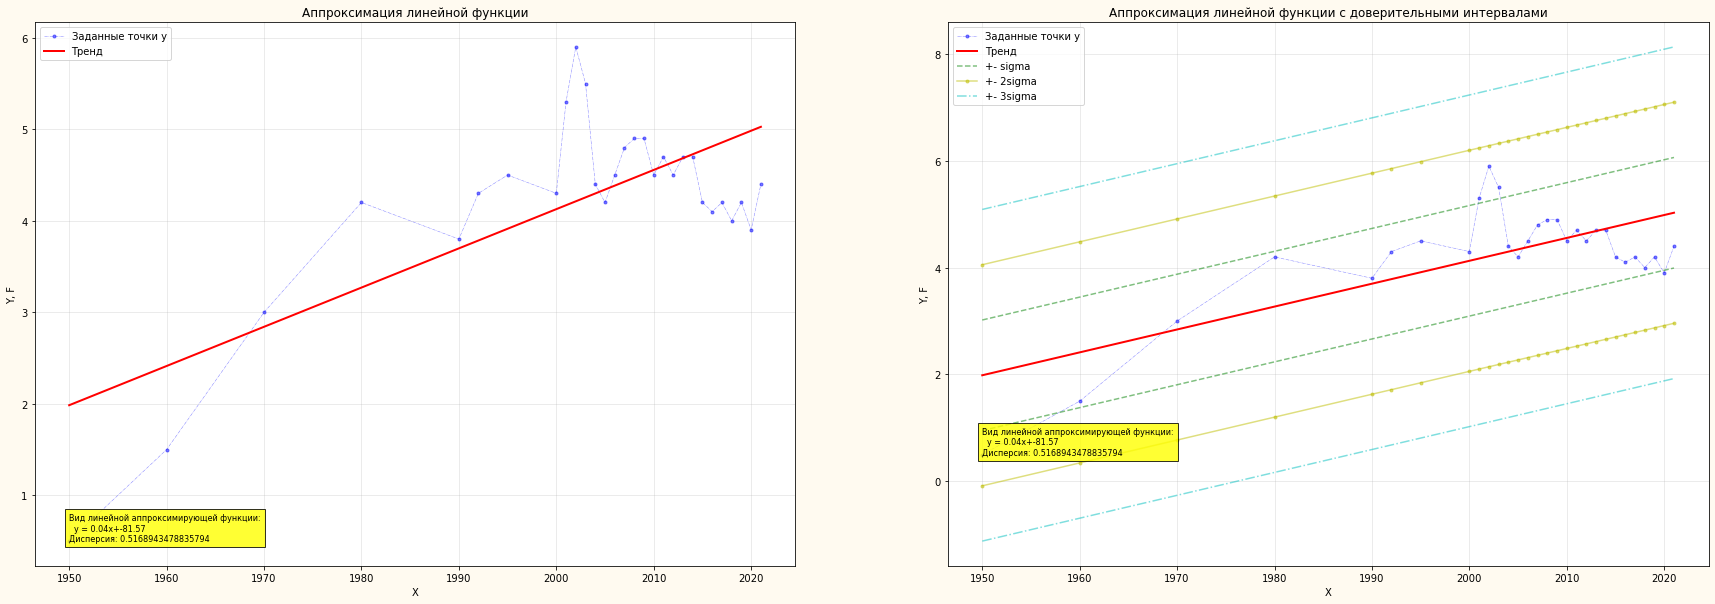


Очищенная выборка



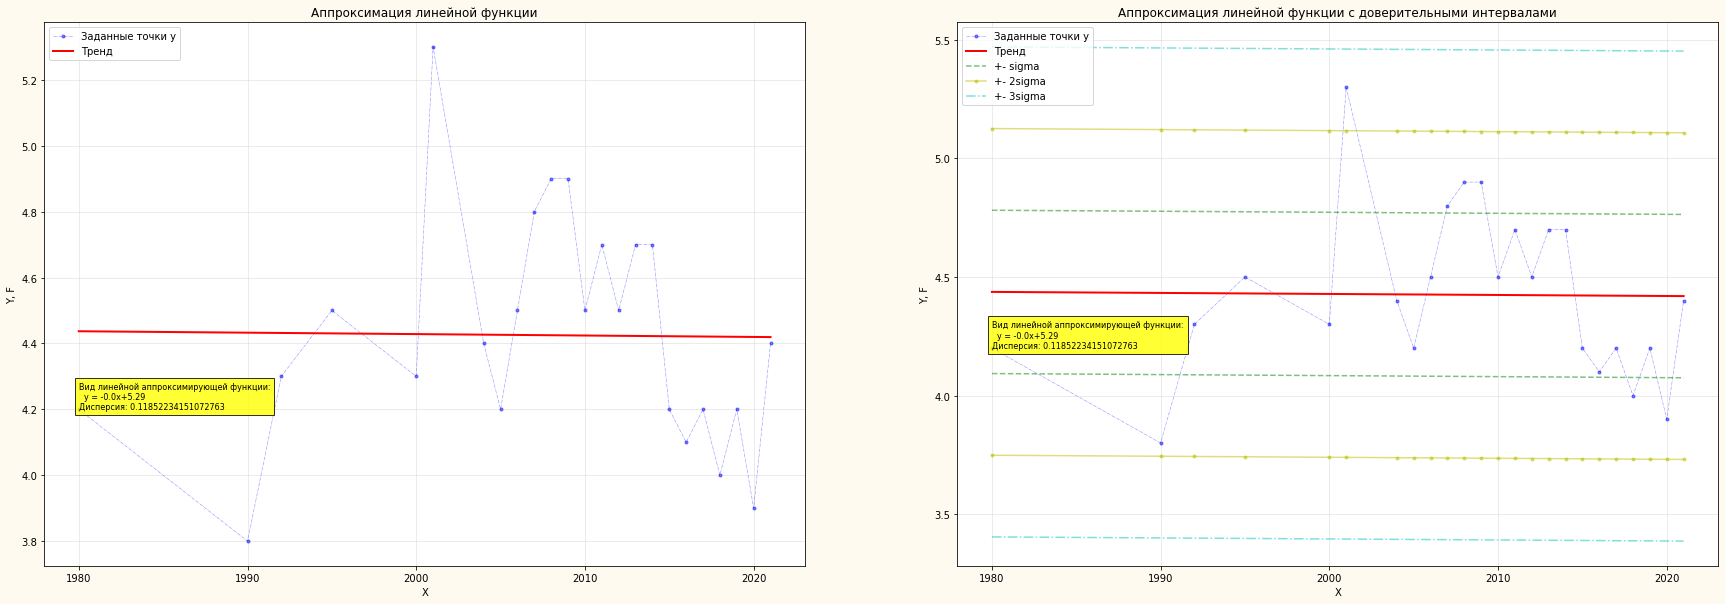


Неочищенная выборка



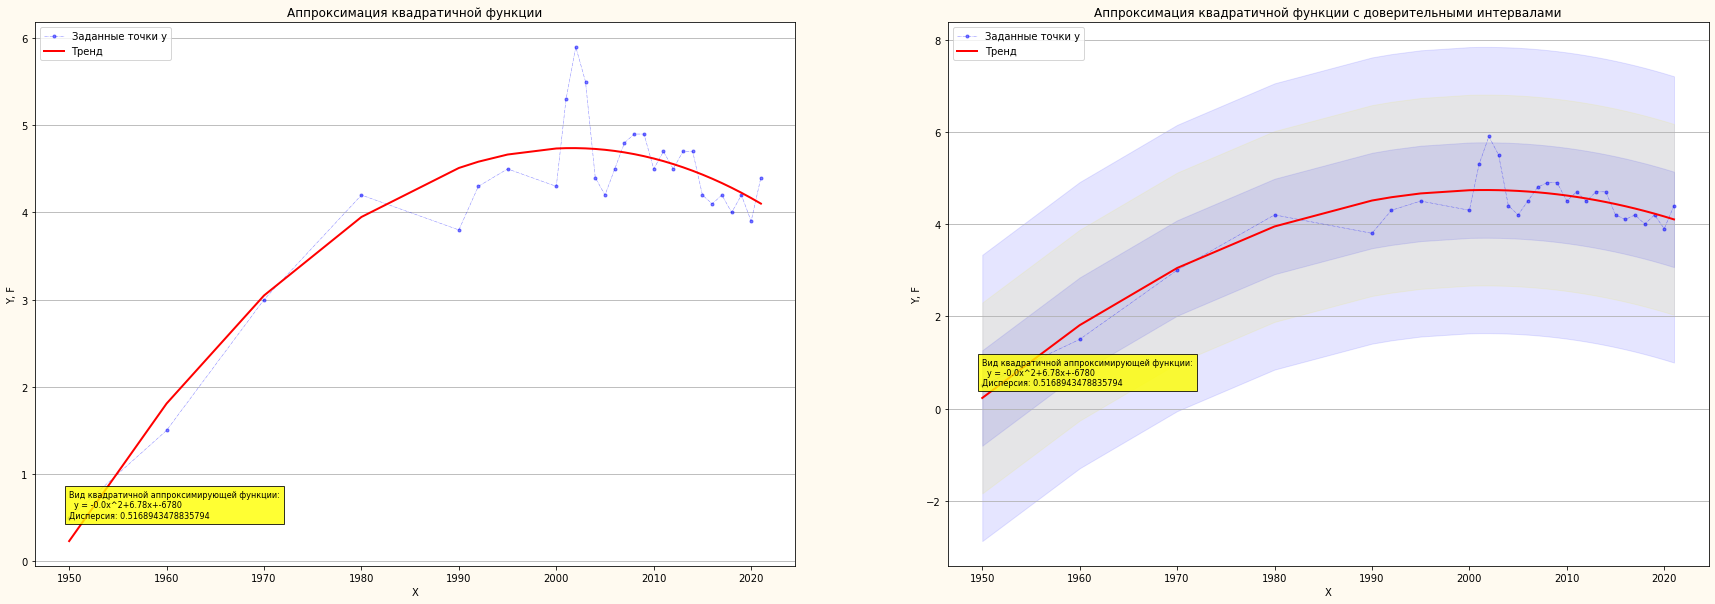


Очищенная выборка



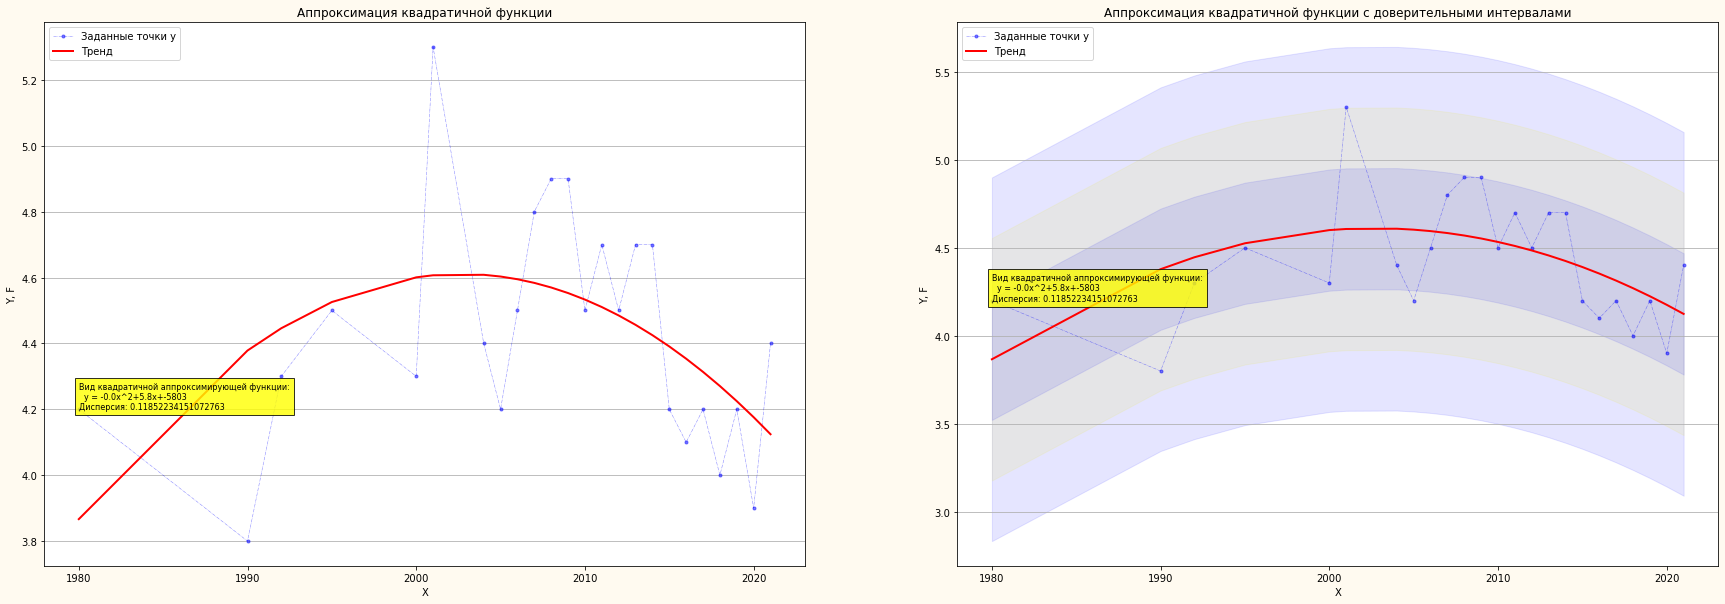

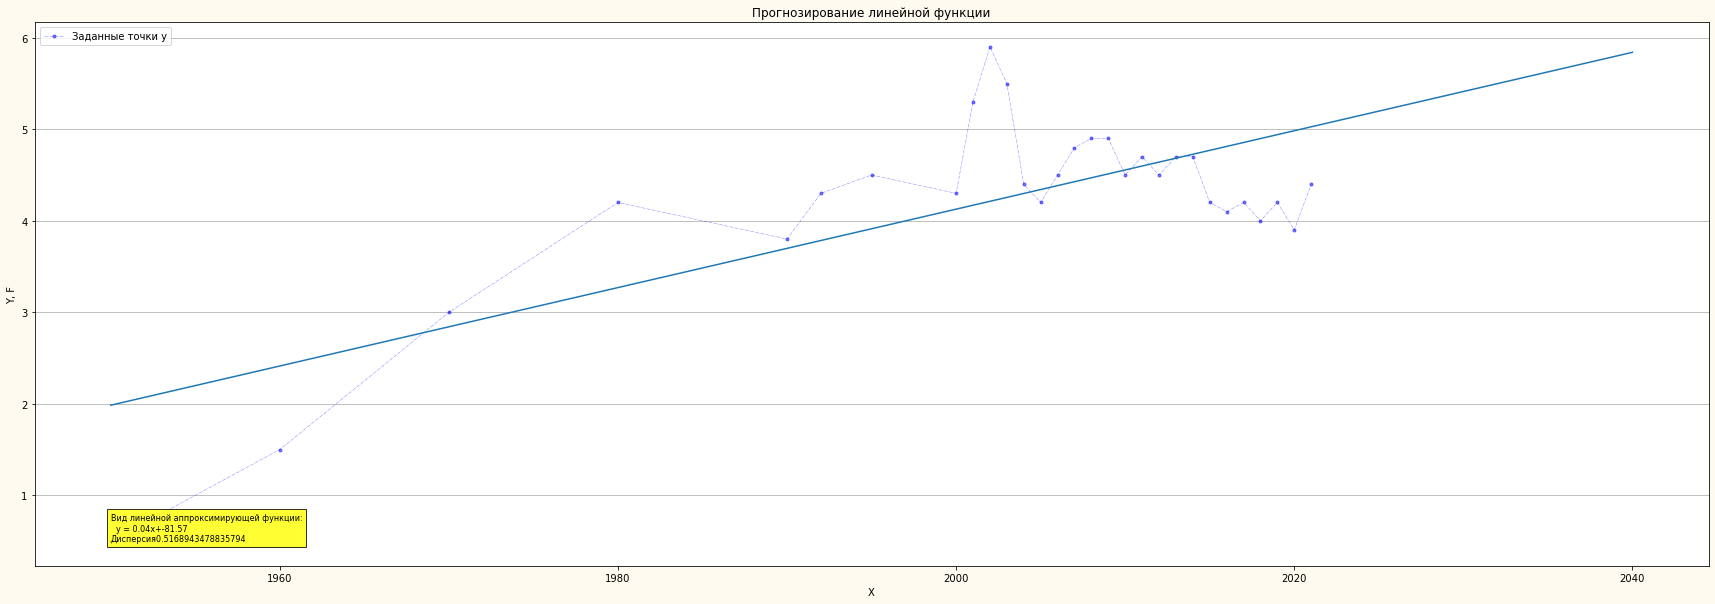

--- 0.3495442867279053 секунд ---
[1950, 1960, 1970, 1980, 1990, 1992, 1995, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2040] [1.9846612697065495, 2.4131515409747237, 2.841641812242912, 3.2701320835110863, 3.6986223547792747, 3.7843204090329152, 3.912867490413362, 4.127112626047463, 4.169961653174283, 4.212810680301089, 4.25565970742791, 4.29850873455473, 4.34135776168155, 4.3842067888083704, 4.427055815935191, 4.469904843062011, 4.512753870188817, 4.555602897315637, 4.5984519244424575, 4.641300951569278, 4.684149978696098, 4.726999005822918, 4.769848032949739, 4.812697060076545, 4.855546087203365, 4.898395114330185, 4.941244141457005, 4.984093168583826, 5.026942195710646, 5.841073711120188] 30 30


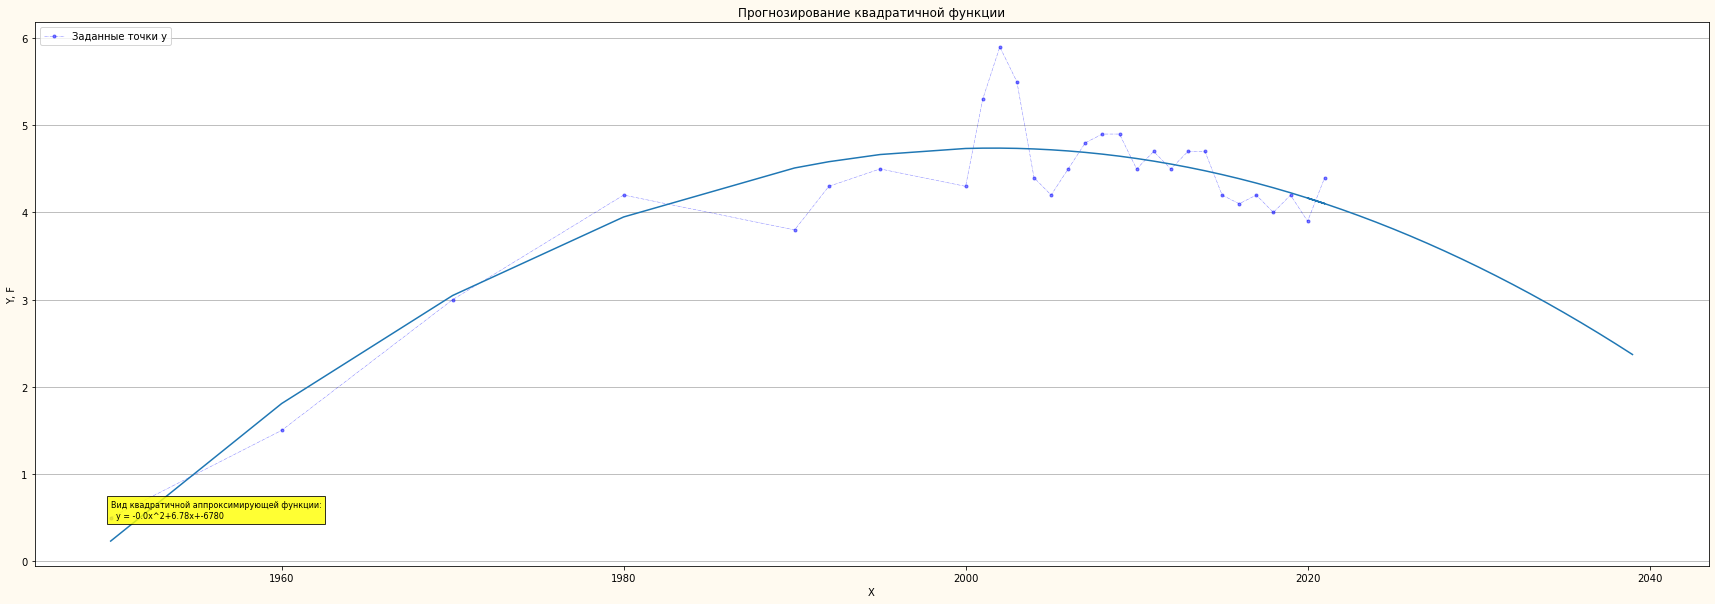

--- 0.35591578483581543 секунд ---
[1950, 1960, 1970, 1980, 1990, 1992, 1995, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039] [0.2295002918199316, 1.8079186775248672, 3.0476369200405315, 3.948655019369653, 4.510972975512232, 4.58279254955869, 4.665119399887772, 4.734590788468267, 4.738324061887397, 4.738670333877053, 4.735629604432688, 4.72920187355885, 4.719387141250081, 4.7061854075127485, 4.689596672340485, 4.669620935738749, 4.646258197702991, 4.61950845823776, 4.5893717173385085, 4.555847975008874, 4.518937231246127, 4.478639486052998, 4.434954739426757, 4.387882991370134, 4.337424241879489, 4.283578490959371, 4.226345738605232, 4.16572598482071, 4.101719229603077, 4.16572598482071, 4.101719229603077, 4.034325472955061, 3.9635447148730236, 3.889376955361513, 3.8118221944159814, 3.

In [18]:
print('Апроксимированные значения: ',prog.array_f())
print(prog.function_str()[0])
print(prog.function_str()[1])
print('Значение дисперсии: ',(prog.sigma())**2)
prog_cleaned = prognoz(iqr.dir())
print('\nНеочищенная выборка\n')
prog.draw_board()
print('\nОчищенная выборка\n')
prog_cleaned.draw_board()
print('\nНеочищенная выборка\n')
prog.draw_board_f2()
print('\nОчищенная выборка\n')
prog_cleaned.draw_board_f2()
prog.draw_predict(pred_x = [2040])
prog.draw_predict_square(pred_x = [i for i in range (2020,2040)])
print('Отклонение линейной: ',prog.otklon_funct())
print('Отклонение квадратичной: ',prog_cleaned.otklon_funct())

Задание №1.3 Очистка от выбросов

In [8]:
iqr = clean_csv(input('Введите название: '))

Введите название: help.csv


       X    Y
0   1950  0.5
1   1960  1.5
2   1970  3.0
3   1980  4.2
4   1990  3.8
5   1992  4.3
6   1995  4.5
7   2000  4.3
8   2001  5.3
9   2002  5.9
10  2003  5.5
11  2004  4.4
12  2005  4.2
13  2006  4.5
14  2007  4.8
15  2008  4.9
16  2009  4.9
17  2010  4.5
18  2011  4.7
19  2012  4.5
20  2013  4.7
21  2014  4.7
22  2015  4.2
23  2016  4.1
24  2017  4.2
25  2018  4.0
26  2019  4.2
27  2020  3.9
28  2021  4.4
       X    Y
3   1980  4.2
4   1990  3.8
5   1992  4.3
6   1995  4.5
7   2000  4.3
8   2001  5.3
11  2004  4.4
12  2005  4.2
13  2006  4.5
14  2007  4.8
15  2008  4.9
16  2009  4.9
17  2010  4.5
18  2011  4.7
19  2012  4.5
20  2013  4.7
21  2014  4.7
22  2015  4.2
23  2016  4.1
24  2017  4.2
25  2018  4.0
26  2019  4.2
27  2020  3.9
28  2021  4.4
0.9848018847719003
AxesSubplot(0.125,0.125;0.775x0.755)
Файл в режиме работы. Закройте файл и повторите попытку!
1


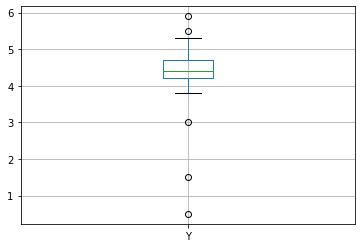

In [9]:

class clean_csv:
    ''' 
    Класс для очистки от выбросов. Обязательные параметры: название файла.
                                   Необязательные параметры: Процент доступных для исключения точек.
                                                             Максимальное количества итераций
                                                             Название нового, очищенного от выбросов файла
        '''
    def __init__(self, csv, portion = 0.1, max_iter=1000, file_name = 'cleaned_xy.csv'):
        self.csv = csv
        self.portion = portion
        self.max_iter = max_iter
        self.file_name = file_name
        
    def csv_file(self):
        return(pd.read_csv(self.csv, sep =';', decimal = ','))
    
    def boxplot(self):
        csv = clean_csv.csv_file(self)
        boxplot = csv.boxplot(['Y'])
        return(boxplot)
        
    def clean(self):
        csv = clean_csv.csv_file(self)
        for en, x in enumerate(['Y']):
            if en == self.max_iter:
                break
            q_75,q_25 = np.percentile(csv.loc[:,x],[75,25])
            intr_qr = q_75-q_25

            max = q_75+(1.5*intr_qr)
            min = q_25-(1.5*intr_qr)
    
            csv.loc[csv[x] < min,x] = np.nan
            csv.loc[csv[x] > max,x] = np.nan
        csv.isnull().sum()
        csv = csv.dropna(axis = 0)
        return(csv)
    
    def dispersion_difference(self):
        csv = clean_csv.csv_file(self)
        cleaned = clean_csv.clean(self)
        return(csv['Y'].var()-cleaned['Y'].var())
    
    def create_csv(self):
        csv = clean_csv.clean(self)
        try:
            csv.to_csv(self.file_name, sep=';')
        except PermissionError:
            print('Файл в режиме работы. Закройте файл и повторите попытку!')
        return(os.system(self.file_name))
    
    def dir(self):
        return(os.path.abspath(self.file_name))
    
#iqr = clean_csv('prog.csv')#название файла
print(iqr.csv_file()) #датафрейм
print(iqr.clean()) #очищенная выборка
print(iqr.dispersion_difference()) #пункт 3 в) подсчет разницы дисперсий
print(iqr.boxplot()) #ящик с усами
print(iqr.create_csv()) #открывает файлЫ